# Unified

## Step 0: Import Necessary Libraries

First, we'll ensure all the necessary libraries are imported.

In [1]:
import numpy as np
import time
import torch
import tensorflow as tf
import psutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset
import psutil
import GPUtil


## Step 1: Load the MNIST Dataset

We'll load the MNIST dataset and prepare it for training and testing.

In [2]:
from keras.datasets import mnist

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the 28x28 images into vectors of size 784
X_train = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255

# Convert labels to one-hot encoding for TensorFlow, PyTorch models
y_train_tf = tf.keras.utils.to_categorical(y_train, 10)
y_test_tf = tf.keras.utils.to_categorical(y_test, 10)

# Convert to torch tensors for PyTorch model
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)


## Step 2: Implement Custom Neural Network

Let's start by defining the custom neural network and its training function.

In [3]:
import numpy as np

class CustomNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(hidden_size, input_size) * 0.01
        #self.b1 = np.zeros((hidden_size, 1))
        self.b1 = np.random.randn(hidden_size, 1) * 0.01
        self.W2 = np.random.randn(output_size, hidden_size) * 0.01
        #self.b2 = np.zeros((output_size, 1))
        self.b2 = np.random.randn(output_size, 1) * 0.01

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)

    def forward(self, X):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = self.relu(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def compute_loss(self, A2, Y):
        #m = Y.shape[1]
        m = Y.shape[0]
        log_probs = -np.log(A2[Y, range(m)])
        loss = np.sum(log_probs) / m
        return loss

    def backward(self, X, Y, Z1, A1, Z2, A2):
        m = X.shape[1]
        dZ2 = A2 - Y
        dW2 = np.dot(dZ2, A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * (Z1 > 0)
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m
        return dW1, db1, dW2, db2

    def update_params(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def one_hot(self, Y):
        ''' return an 0 vector with 1 only in the position correspondind to the value in Y'''
        one_hot_Y = np.zeros((Y.max()+1,Y.size)) #si le chiffre le plus grand dans Y est 9 ca fait 10 lignes
        one_hot_Y[Y,np.arange(Y.size)] = 1 # met un 1 en ligne Y[i] et en colonne i, change l'ordre mais pas le nombre
        return one_hot_Y

    @staticmethod
    def compute_auc(fpr, tpr):
        return np.trapz(tpr, fpr)
    
    @staticmethod
    def compute_roc_auc(Y_true, Y_probs):
        thresholds = np.sort(Y_probs)[::-1]
        tps = []
        fps = []
        tpr = []
        fpr = []

        P = np.sum(Y_true == 1)
        N = np.sum(Y_true == 0)

        for threshold in thresholds:
            TP = np.sum((Y_probs >= threshold) & (Y_true == 1))
            FP = np.sum((Y_probs >= threshold) & (Y_true == 0))

            TPR = TP / P
            FPR = FP / N

            tps.append(TP)
            fps.append(FP)
            tpr.append(TPR)
            fpr.append(FPR)

        fps, tps = np.array(fps), np.array(tps)
        fpr, tpr = np.array(fpr), np.array(tpr)
        
        return [fps, tps, fpr, tpr, thresholds]


    def train(self, X, Y, epochs, learning_rate, get_ROC_AUC="custom"):
        Y_one_hot = np.eye(10)[Y].T
        #Y_one_hot = self.one_hot(Y)
        roc_aucs = []
        accuracies = []
        losses = []

        for epoch in range(epochs):
            Z1, A1, Z2, A2 = self.forward(X)
            loss = self.compute_loss(A2, Y)
            dW1, db1, dW2, db2 = self.backward(X, Y_one_hot, Z1, A1, Z2, A2)
            self.update_params(dW1, db1, dW2, db2, learning_rate)
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss:.4f}')
            
            if (epoch+1) % int(epochs/10) == 0:
                print(f"Iteration: {epoch+1} / {epochs}")
                #prediction = self.predict(A2, X)
                prediction = self.predict(X)
                accuracy = self.get_accuracy(prediction, Y)
                print(f'{accuracy:.3%}')
                accuracies.append(accuracy)
                losses.append(loss)

                if (get_ROC_AUC == "custom"):
                    # Calculate ROC and AUC manually
                    values = self.compute_roc_auc(Y_one_hot[1], A2[1])
                    auc = self.compute_auc(values[2], values[3])
                #elif (get_ROC_AUC == "fast"):
                #    from sklearn.metrics import roc_auc_score, roc_curve
                #    fpr, tpr, thresholds = roc_curve(Y_one_hot.T, A2.T)#, multi_class='ovr')
                #    auc = roc_auc_score(fpr, tpr)
                roc_aucs.append([auc]+values)

        
        weights = [self.W1, self.b1, self.W2, self.b2]
        return weights, roc_aucs, accuracies, losses

    def predict(self, X):
        _, _, _, A2 = self.forward(X)
        return np.argmax(A2, axis=0)
    
    def predict_proba(self, X):
        _, _, _, A2 = self.forward(X)
        return A2
    
    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y)/Y.size
    
    def show_prediction(self, index, X, Y, W1, b1, W2, b2, WIDTH, HEIGHT, SCALE_FACTOR):
        # None => cree un nouvel axe de dimension 1, cela a pour effet de transposer X[:,index] qui un np.array de dimension 1 (ligne) et qui devient un vecteur (colonne)
        #  ce qui correspond bien a ce qui est demande par make_predictions qui attend une matrice dont les colonnes sont les pixels de l'image, la on donne une seule colonne
        vect_X = X[:, index,None]
        prediction = self.predict(vect_X)
        label = Y[index]
        print("Prediction: ", prediction)
        print("Label: ", label)

        current_image = vect_X.reshape((WIDTH, HEIGHT)) * SCALE_FACTOR

        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()


In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
SCALE_FACTOR = 255 # TRES IMPORTANT SINON OVERFLOW SUR EXP
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0],WIDTH*HEIGHT).T / SCALE_FACTOR
X_test = X_test.reshape(X_test.shape[0],WIDTH*HEIGHT).T  / SCALE_FACTOR
print(np.shape(X_train))

# Custom NN
custom_nn = CustomNN(input_size=784, hidden_size=128, output_size=10)
# Train all models
epochs = 100
batch_size = 64
# Custom NN
weights, roc_aucs_nn, accuracies_nn, losses_nn = custom_nn.train(X_train, Y_train, epochs=epochs, learning_rate=0.01, get_ROC_AUC="custom")
W1, b1, W2, b2 = weights

#custom_nn.show_prediction(0, X_test, Y_test, W1, b1, W2, b2, WIDTH, HEIGHT, SCALE_FACTOR)


(784, 60000)
Epoch 0, Loss: 2.3024
Iteration: 10 / 100
9.922%
Iteration: 20 / 100
11.318%
Iteration: 30 / 100
14.005%
Iteration: 40 / 100
17.105%
Iteration: 50 / 100
19.525%
Iteration: 60 / 100
21.565%
Iteration: 70 / 100
23.667%
Iteration: 80 / 100
26.058%
Iteration: 90 / 100
28.713%
Iteration: 100 / 100
32.113%


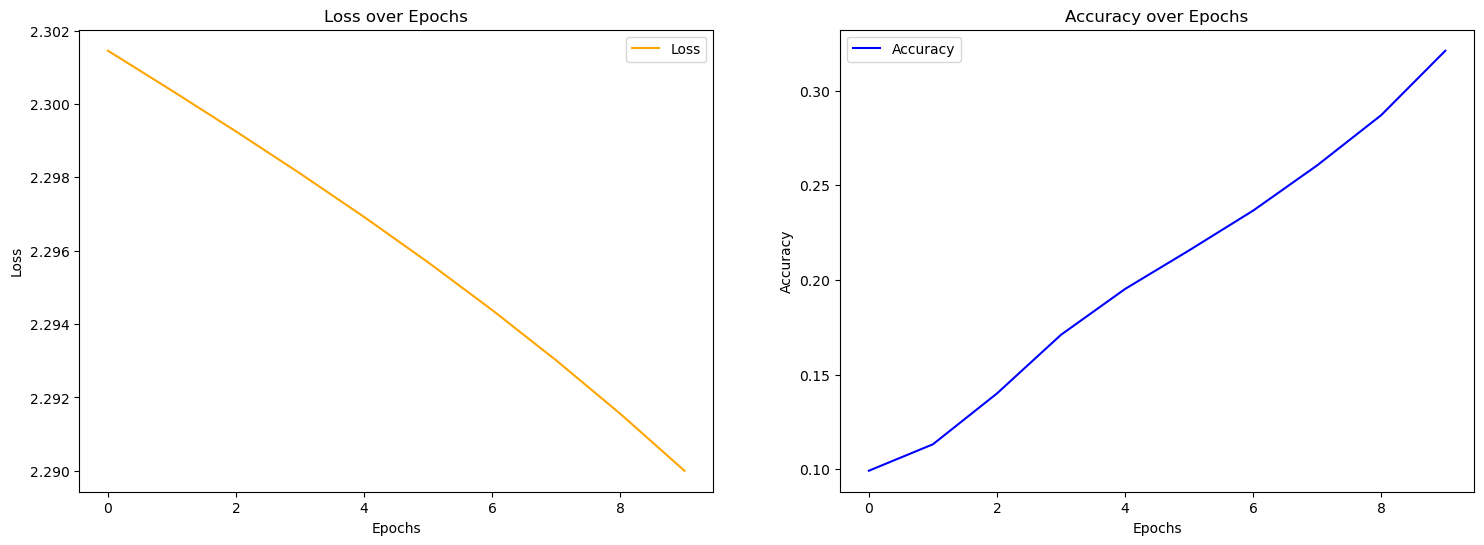

In [5]:
def plot_metrics(accuracies, losses, epochs):
    xs = np.arange(epochs//10)

    plt.figure(figsize=(18, 6))
    
    # Plot Loss over Epochs
    plt.subplot(1, 2, 1)
    plt.plot(xs, losses, label='Loss', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy over Epochs
    plt.subplot(1, 2, 2)
    plt.plot(xs, accuracies, label='Accuracy', color='blue')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()



plot_metrics(accuracies_nn, losses_nn, epochs)

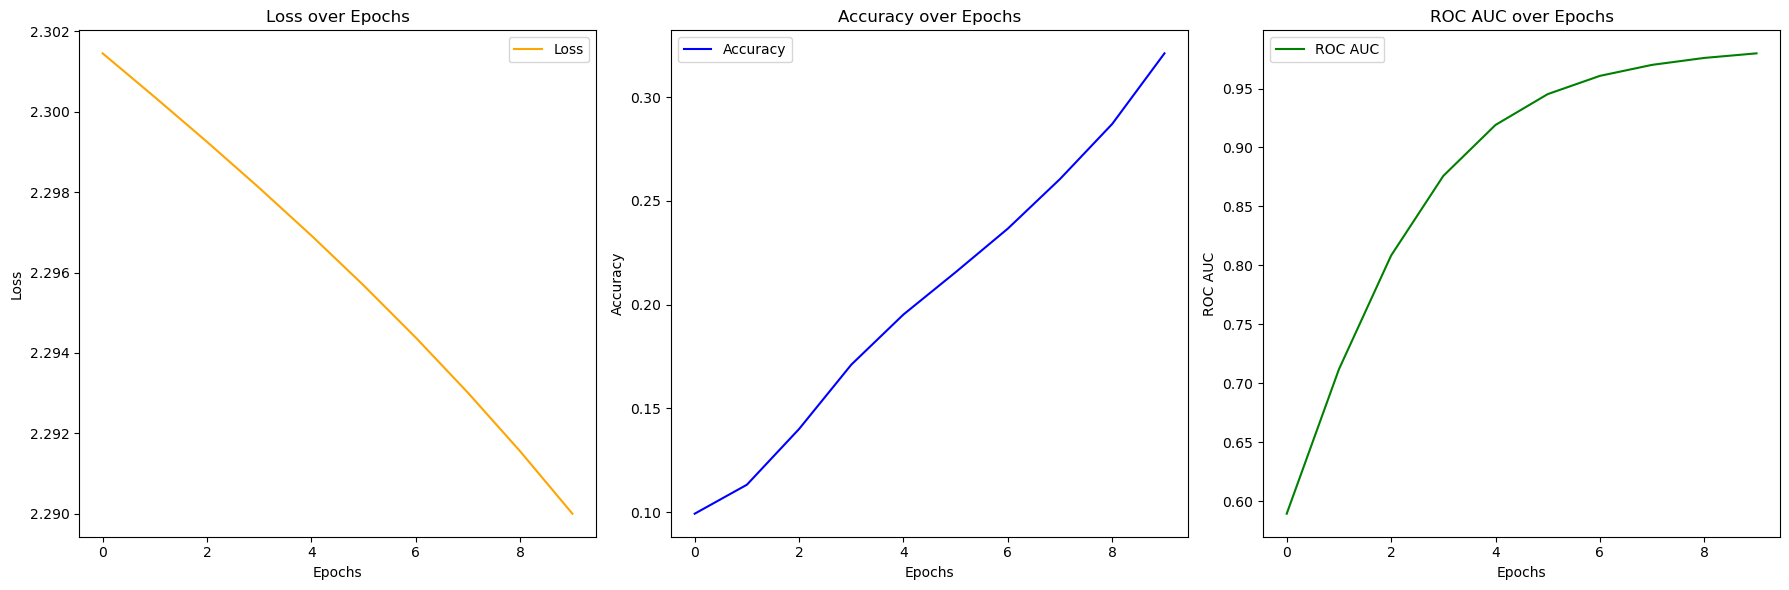

In [6]:
def plot_metrics(roc_aucs, accuracies, losses, epochs):
    xs = np.arange(epochs // 10)

    plt.figure(figsize=(18, 6))
    
    # Plot Loss over Epochs
    plt.subplot(1, 3, 1)
    plt.plot(xs, losses, label='Loss', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy over Epochs
    plt.subplot(1, 3, 2)
    plt.plot(xs, accuracies, label='Accuracy', color='blue')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot ROC AUC over Epochs
    plt.subplot(1, 3, 3)
    roc_auc_values = [auc for auc, _, _, _, _, _ in roc_aucs]
    plt.plot(xs, roc_auc_values, label='ROC AUC', color='green')
    plt.title('ROC AUC over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('ROC AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

    

plot_metrics(roc_aucs_nn, accuracies_nn, losses_nn, epochs)


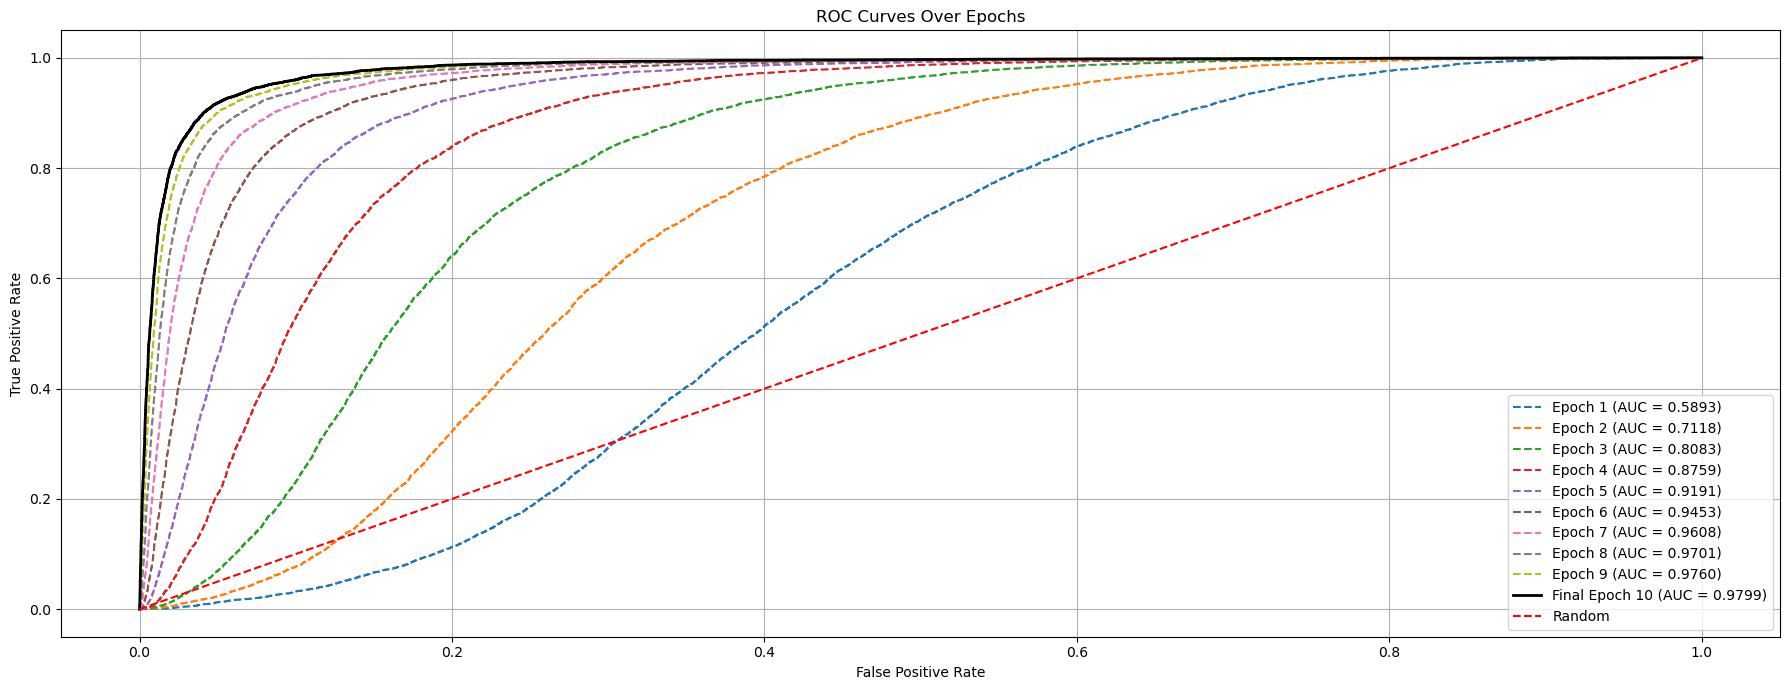

In [7]:
import matplotlib.pyplot as plt
import numpy as np


# Plot ROC Curves for all epochs
plt.figure(figsize=(18, 7))

roc_aucs = roc_aucs_nn

# ROC Curve Plot
#plt.subplot(1, 2, 1)
for i, (auc, fps, tps, fpr, tpr, thresholds) in enumerate(roc_aucs):
    if i == len(roc_aucs) - 1:
        plt.plot(fpr, tpr, label=f'Final Epoch {i + 1} (AUC = {auc:.4f})', color='black', linewidth=2)
    else:
        plt.plot(fpr, tpr, label=f'Epoch {i + 1} (AUC = {auc:.4f})', linestyle='--')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.title('ROC Curves Over Epochs')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Step 3: Implement PyTorch Neural Network

Here is the PyTorch implementation for a simple neural network.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PyTorchNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def pytorch_train(model, X_train, y_train, batch_size, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=True)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


## Step 4: Implement TensorFlow Neural Network

Here is the TensorFlow implementation for the neural network.

In [9]:
import tensorflow as tf

def create_tf_model(input_size, hidden_size, output_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_size, activation='relu', input_shape=(input_size,)),
        tf.keras.layers.Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def tf_train(model, X_train, y_train, batch_size, device):
    model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0)


## Step 5: Implement Scikit-Learn Neural Network

Here is the Scikit-Learn implementation using MLPClassifier.

In [10]:
from sklearn.neural_network import MLPClassifier

def create_sklearn_model(input_size, hidden_size, output_size):
    model = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=1, warm_start=True)
    return model

def sklearn_train(model, X_train, y_train, batch_size, device):
    model.fit(X_train, y_train)


## Step 2: Unified Training Loop Function

This function handles training and evaluation for each model and logs CPU, GPU, and memory usage.

In [11]:
def train_model(model, train_func, X_train, y_train, X_test, y_test, epochs, batch_size, use_gpu=False):
    device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
    cpu_usage = []
    gpu_usage = []
    memory_usage = []
    accuracies = []
    losses = []

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        
        # CPU & Memory Usage Monitoring
        cpu_before = psutil.cpu_percent(interval=None)
        mem_before = psutil.virtual_memory().percent

        # GPU Usage Monitoring (using GPUtil)
        gpu_before = 0
        if use_gpu:
            gpus = GPUtil.getGPUs()
            if gpus:
                gpu_before = gpus[0].load * 100  # GPU load in percentage

        # Training Step
        train_func(model, X_train, y_train, batch_size, device)
        
        # Evaluation
        accuracy, loss = evaluate_model(model, X_test, y_test, batch_size, device)
        
        # CPU & Memory Usage Monitoring after training step
        cpu_after = psutil.cpu_percent(interval=None)
        mem_after = psutil.virtual_memory().percent
        
        # GPU Usage Monitoring after training step
        gpu_after = 0
        if use_gpu:
            gpus = GPUtil.getGPUs()
            if gpus:
                gpu_after = gpus[0].load * 100  # GPU load in percentage

        # Log Usage
        cpu_usage.append(cpu_after - cpu_before)
        gpu_usage.append(gpu_after - gpu_before)
        memory_usage.append(mem_after - mem_before)
        accuracies.append(accuracy)
        losses.append(loss)
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Time: {time.time() - epoch_start:.2f}s')

    total_time = time.time() - start_time
    return total_time, cpu_usage, gpu_usage, memory_usage, accuracies, losses

## Step 3: Evaluation Function

This function evaluates the model's performance on the test set and returns the accuracy and loss.

In [12]:
def evaluate_model(model, X_test, y_test, batch_size, device):
    if isinstance(model, torch.nn.Module):
        model.eval()
        correct = 0
        total = 0
        loss = 0.0
        criterion = torch.nn.CrossEntropyLoss()
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                inputs = torch.tensor(X_test[i:i+batch_size], dtype=torch.float).to(device)
                labels = torch.tensor(y_test[i:i+batch_size], dtype=torch.long).to(device)
                outputs = model(inputs)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        loss /= total
    elif isinstance(model, tf.keras.Model):
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    elif isinstance(model, MLPClassifier):
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        loss = 0  # Implement loss calculation as needed
    return accuracy, loss

# TODO: Add ROC, AUC, Accuracy, Loss, for all of these models

## Step 6: Instantiate and Train Models

Now we can instantiate each model and use the unified training loop to train them.

In [2]:
# Custom NN
custom_nn = CustomNN(input_size=784, hidden_size=128, output_size=10)

# PyTorch NN
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
pytorch_model = PyTorchNN(input_size=784, hidden_size=128, output_size=10).to(device)

# TensorFlow NN
tf_model = create_tf_model(input_size=784, hidden_size=128, output_size=10)

# Scikit-Learn NN
sklearn_model = create_sklearn_model(input_size=784, hidden_size=128, output_size=10)

NameError: name 'torch' is not defined

In [19]:
# Custom NN
custom_nn = CustomNN(input_size=784, hidden_size=128, output_size=10)


In [20]:
# Train all models
epochs = 100
batch_size = 64

In [21]:
# Custom NN
custom_nn.train(X_train.T, y_train, epochs=epochs, learning_rate=0.01)

Epoch 0, Loss: 2.3025
Iteration: 10 / 100


TypeError: CustomNN.predict() takes 2 positional arguments but 3 were given

In [35]:
# PyTorch NN
train_model(pytorch_model, pytorch_train, X_train, y_train, X_test, y_test, epochs, batch_size, use_gpu=True)

Epoch 1/10 - Loss: 0.0030, Accuracy: 94.3300, Time: 1.72s
Epoch 2/10 - Loss: 0.0019, Accuracy: 96.3000, Time: 1.45s
Epoch 3/10 - Loss: 0.0016, Accuracy: 96.8600, Time: 1.54s
Epoch 4/10 - Loss: 0.0015, Accuracy: 96.9800, Time: 1.49s
Epoch 5/10 - Loss: 0.0013, Accuracy: 97.5300, Time: 1.51s
Epoch 6/10 - Loss: 0.0013, Accuracy: 97.3100, Time: 1.47s
Epoch 7/10 - Loss: 0.0011, Accuracy: 97.9200, Time: 1.54s
Epoch 8/10 - Loss: 0.0011, Accuracy: 97.7900, Time: 1.59s
Epoch 9/10 - Loss: 0.0011, Accuracy: 97.8700, Time: 1.42s
Epoch 10/10 - Loss: 0.0011, Accuracy: 97.9800, Time: 1.53s


(15.263686656951904,
 [5.1,
  -28.6,
  -21.099999999999998,
  -24.900000000000002,
  -29.799999999999997,
  -29.2,
  -22.099999999999998,
  -23.700000000000003,
  -23.300000000000004,
  -33.7],
 [14.0,
  11.0,
  1.0,
  18.0,
  -4.0,
  -3.0,
  3.0,
  -7.9999999999999964,
  2.9999999999999964,
  5.0],
 [0.5999999999999943,
  0.0,
  -0.20000000000000284,
  -0.09999999999999432,
  -0.10000000000000853,
  0.0,
  0.0,
  0.0,
  0.09999999999999432,
  0.0],
 [94.33, 96.3, 96.86, 96.98, 97.53, 97.31, 97.92, 97.79, 97.87, 97.98],
 [0.003036821118928492,
  0.0019309335181955248,
  0.001581528949656058,
  0.001462266211793758,
  0.0012512619392888154,
  0.0013261175644292962,
  0.0011207317030843115,
  0.001119750519162335,
  0.0011412763448854094,
  0.0010881908963136084])

In [36]:
# TensorFlow NN
train_model(tf_model, tf_train, X_train, y_train_tf, X_test, y_test_tf, epochs, batch_size, use_gpu=True)

Epoch 1/10 - Loss: 0.1571, Accuracy: 0.9548, Time: 1.68s
Epoch 2/10 - Loss: 0.1166, Accuracy: 0.9651, Time: 1.23s
Epoch 3/10 - Loss: 0.0975, Accuracy: 0.9696, Time: 1.19s
Epoch 4/10 - Loss: 0.0863, Accuracy: 0.9737, Time: 1.25s
Epoch 5/10 - Loss: 0.0916, Accuracy: 0.9703, Time: 1.15s
Epoch 6/10 - Loss: 0.0764, Accuracy: 0.9768, Time: 1.15s
Epoch 7/10 - Loss: 0.0744, Accuracy: 0.9778, Time: 1.16s
Epoch 8/10 - Loss: 0.0722, Accuracy: 0.9778, Time: 1.16s
Epoch 9/10 - Loss: 0.0686, Accuracy: 0.9794, Time: 1.15s
Epoch 10/10 - Loss: 0.0790, Accuracy: 0.9762, Time: 1.16s


(12.2732093334198,
 [-30.799999999999997,
  1.5,
  -5.1,
  -13.5,
  -9.0,
  -1.3000000000000007,
  -3.3000000000000003,
  -1.5,
  -5.199999999999999,
  -3.7],
 [-17.0,
  9.000000000000002,
  -3.0000000000000018,
  -1.0,
  -2.0,
  -1.0,
  6.000000000000002,
  0.0,
  0.0,
  0.0],
 [0.09999999999999432,
  0.0,
  0.0,
  -0.5,
  -0.10000000000000853,
  -0.09999999999999432,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.954800009727478,
  0.9650999903678894,
  0.9696000218391418,
  0.9736999869346619,
  0.970300018787384,
  0.9768000245094299,
  0.9778000116348267,
  0.9778000116348267,
  0.9793999791145325,
  0.9761999845504761],
 [0.1571187674999237,
  0.11657796800136566,
  0.09749776870012283,
  0.08634015917778015,
  0.09157724678516388,
  0.07636569440364838,
  0.07444898039102554,
  0.07215924561023712,
  0.0685940831899643,
  0.07897362112998962])

In [17]:
# Scikit-Learn NN
train_model(sklearn_model, sklearn_train, X_train, y_train, X_test, y_test, epochs, batch_size, use_gpu=False)

c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/10 - Loss: 0.0000, Accuracy: 0.9358, Time: 0.44s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 2/10 - Loss: 0.0000, Accuracy: 0.9560, Time: 0.42s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 3/10 - Loss: 0.0000, Accuracy: 0.9642, Time: 0.42s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 4/10 - Loss: 0.0000, Accuracy: 0.9694, Time: 0.42s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 5/10 - Loss: 0.0000, Accuracy: 0.9719, Time: 0.42s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 6/10 - Loss: 0.0000, Accuracy: 0.9750, Time: 0.43s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 7/10 - Loss: 0.0000, Accuracy: 0.9733, Time: 0.42s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 8/10 - Loss: 0.0000, Accuracy: 0.9764, Time: 0.42s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 9/10 - Loss: 0.0000, Accuracy: 0.9758, Time: 0.42s
Epoch 10/10 - Loss: 0.0000, Accuracy: 0.9772, Time: 0.42s


c:\Programming\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


(4.24120020866394,
 [0.5999999999999996, 10.2, 8.9, 10.2, 9.3, 10.4, 9.8, 9.6, 10.1, 9.8],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0.09999999999999432, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.9358,
  0.956,
  0.9642,
  0.9694,
  0.9719,
  0.975,
  0.9733,
  0.9764,
  0.9758,
  0.9772],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Step 4: Visualization Function

This function will visualize the results for accuracy, loss, and resource usage.

In [40]:
def plot_results(epochs, accuracies, losses, cpu_usage, gpu_usage, memory_usage, model_name):
    plt.figure(figsize=(18, 6))
    
    # Loss
    plt.subplot(2, 2, 1)
    #plt.plot(range(epochs), accuracies, label='Accuracy', color='blue')
    plt.plot(range(epochs), losses, label='Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'{model_name} - Accuracy & Loss over Epochs')
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(range(epochs), accuracies, label='Accuracy', color='blue')
    #plt.plot(range(epochs), losses, label='Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'{model_name} - Accuracy & Loss over Epochs')
    plt.legend()
    
    # CPU Usage
    plt.subplot(2, 2, 3)
    plt.plot(range(epochs), cpu_usage, label='CPU Usage (%)', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('CPU Usage (%)')
    plt.title(f'{model_name} - CPU Usage over Epochs')
    plt.legend()
    
    # GPU Usage
    plt.subplot(2, 2, 4)
    plt.plot(range(epochs), cpu_usage, label='CPU Usage (%)', color='green')

    plt.plot(range(epochs), memory_usage, label='Memory Usage (%)', color='orange')
    if gpu_usage:
        plt.plot(range(epochs), gpu_usage, label='GPU Usage (%)', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Usage (%)')
    plt.title(f'{model_name} - Memory & GPU Usage over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Step 5: Running and Comparing Models on CPU and GPU

Here’s how we will run each model and collect the metrics for comparison.

### CPU

In [53]:
# PyTorch NN
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
pytorch_model = PyTorchNN(input_size=784, hidden_size=128, output_size=10).to(device)

# Example running the PyTorch model on CPU
total_time_cpu, cpu_usage_cpu, gpu_usage_cpu, memory_usage_cpu, accuracies_cpu, losses_cpu = train_model(
    model=pytorch_model, 
    train_func=pytorch_train, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test, 
    epochs=100, 
    batch_size=64, 
    use_gpu=False
)



Epoch 1/100 - Loss: 0.0028, Accuracy: 94.8200, Time: 1.51s
Epoch 2/100 - Loss: 0.0019, Accuracy: 96.3100, Time: 1.45s
Epoch 3/100 - Loss: 0.0015, Accuracy: 97.0900, Time: 1.53s
Epoch 4/100 - Loss: 0.0014, Accuracy: 97.3200, Time: 1.47s
Epoch 5/100 - Loss: 0.0013, Accuracy: 97.4700, Time: 1.53s
Epoch 6/100 - Loss: 0.0012, Accuracy: 97.7300, Time: 1.50s
Epoch 7/100 - Loss: 0.0012, Accuracy: 97.6000, Time: 1.54s
Epoch 8/100 - Loss: 0.0011, Accuracy: 97.8200, Time: 1.54s
Epoch 9/100 - Loss: 0.0013, Accuracy: 97.8100, Time: 1.61s
Epoch 10/100 - Loss: 0.0012, Accuracy: 97.7700, Time: 1.61s
Epoch 11/100 - Loss: 0.0013, Accuracy: 97.7500, Time: 1.56s
Epoch 12/100 - Loss: 0.0012, Accuracy: 98.0100, Time: 1.58s
Epoch 13/100 - Loss: 0.0013, Accuracy: 97.8000, Time: 1.54s
Epoch 14/100 - Loss: 0.0015, Accuracy: 97.7200, Time: 1.60s
Epoch 15/100 - Loss: 0.0014, Accuracy: 97.7900, Time: 1.55s
Epoch 16/100 - Loss: 0.0014, Accuracy: 97.8400, Time: 1.53s
Epoch 17/100 - Loss: 0.0014, Accuracy: 97.8100, T

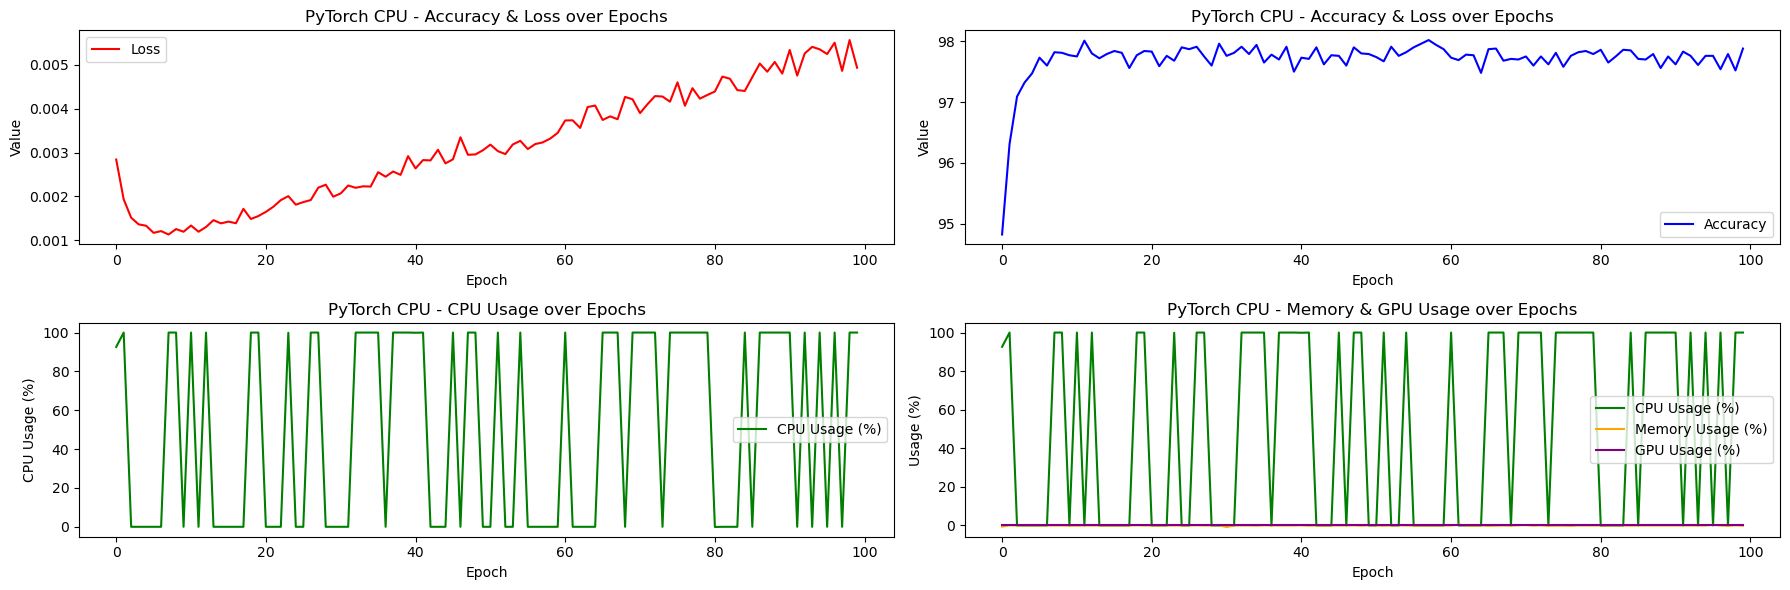

In [55]:

# Plot results for CPU
plot_results(epochs=100, 
             accuracies=accuracies_cpu, 
             losses=losses_cpu, 
             cpu_usage=cpu_usage_cpu, 
             gpu_usage=gpu_usage_cpu, 
             memory_usage=memory_usage_cpu, 
             model_name='PyTorch CPU')

### GPU

Epoch 1/100 - Loss: 0.0029, Accuracy: 94.7400, Time: 1.57s
Epoch 2/100 - Loss: 0.0018, Accuracy: 96.5100, Time: 1.33s
Epoch 3/100 - Loss: 0.0015, Accuracy: 97.0800, Time: 1.40s
Epoch 4/100 - Loss: 0.0013, Accuracy: 97.5400, Time: 1.45s
Epoch 5/100 - Loss: 0.0013, Accuracy: 97.5400, Time: 1.56s
Epoch 6/100 - Loss: 0.0011, Accuracy: 97.8800, Time: 1.48s
Epoch 7/100 - Loss: 0.0011, Accuracy: 97.9300, Time: 1.49s
Epoch 8/100 - Loss: 0.0012, Accuracy: 97.7700, Time: 1.70s
Epoch 9/100 - Loss: 0.0012, Accuracy: 97.8400, Time: 1.76s
Epoch 10/100 - Loss: 0.0013, Accuracy: 97.8100, Time: 2.03s
Epoch 11/100 - Loss: 0.0013, Accuracy: 97.7500, Time: 1.71s
Epoch 12/100 - Loss: 0.0013, Accuracy: 97.7100, Time: 1.92s
Epoch 13/100 - Loss: 0.0014, Accuracy: 97.5800, Time: 1.76s
Epoch 14/100 - Loss: 0.0014, Accuracy: 97.7300, Time: 2.09s
Epoch 15/100 - Loss: 0.0014, Accuracy: 97.7800, Time: 1.82s
Epoch 16/100 - Loss: 0.0014, Accuracy: 98.0200, Time: 1.60s
Epoch 17/100 - Loss: 0.0014, Accuracy: 97.8600, T

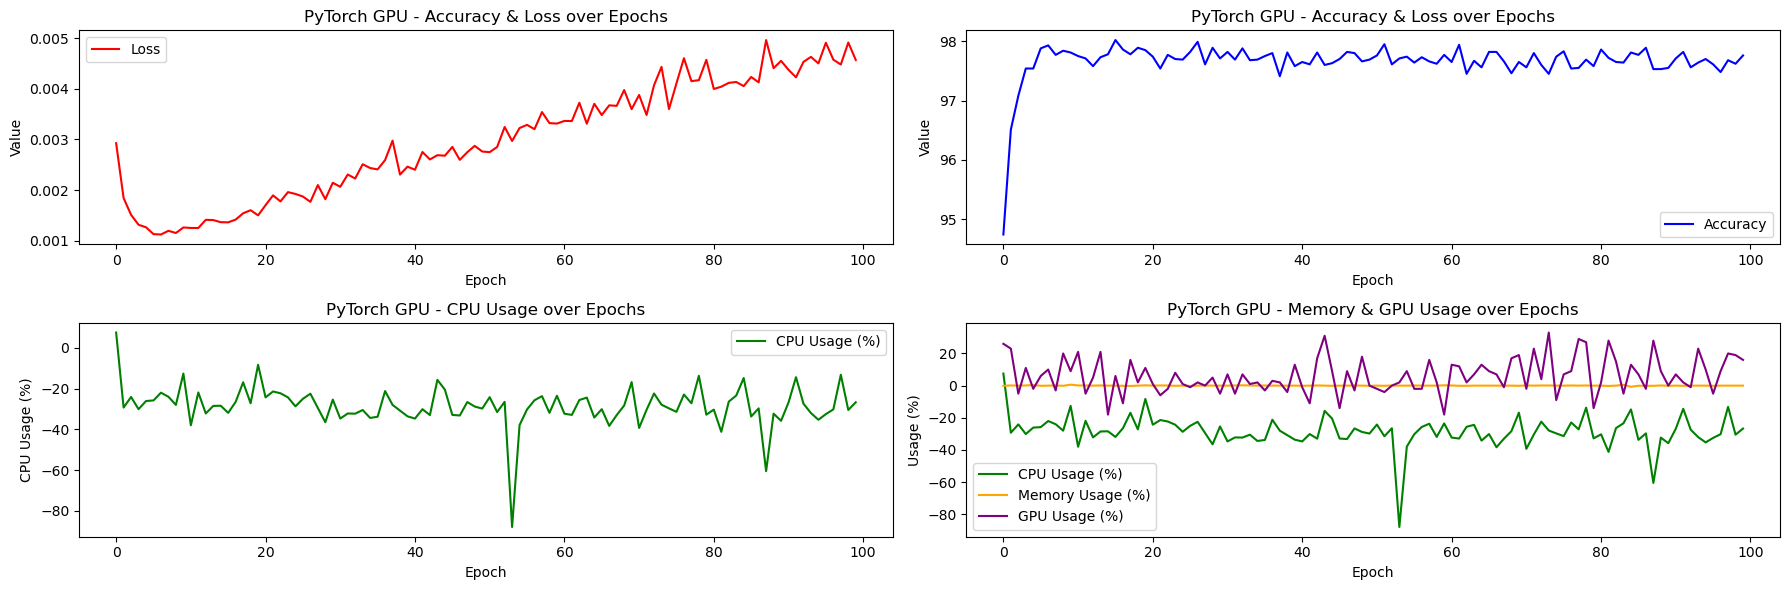

In [52]:
# PyTorch NN
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
pytorch_model = PyTorchNN(input_size=784, hidden_size=128, output_size=10).to(device)

# Example running the PyTorch model on GPU (if available)
if torch.cuda.is_available():
    total_time_gpu, cpu_usage_gpu, gpu_usage_gpu, memory_usage_gpu, accuracies_gpu, losses_gpu = train_model(
        model=pytorch_model, 
        train_func=pytorch_train, 
        X_train=X_train, 
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test, 
        epochs=100, 
        batch_size=64, 
        use_gpu=True
    )

    # Plot results for GPU
    plot_results(epochs=100, 
                 accuracies=accuracies_gpu, 
                 losses=losses_gpu, 
                 cpu_usage=cpu_usage_gpu, 
                 gpu_usage=gpu_usage_gpu, 
                 memory_usage=memory_usage_gpu, 
                 model_name='PyTorch GPU')


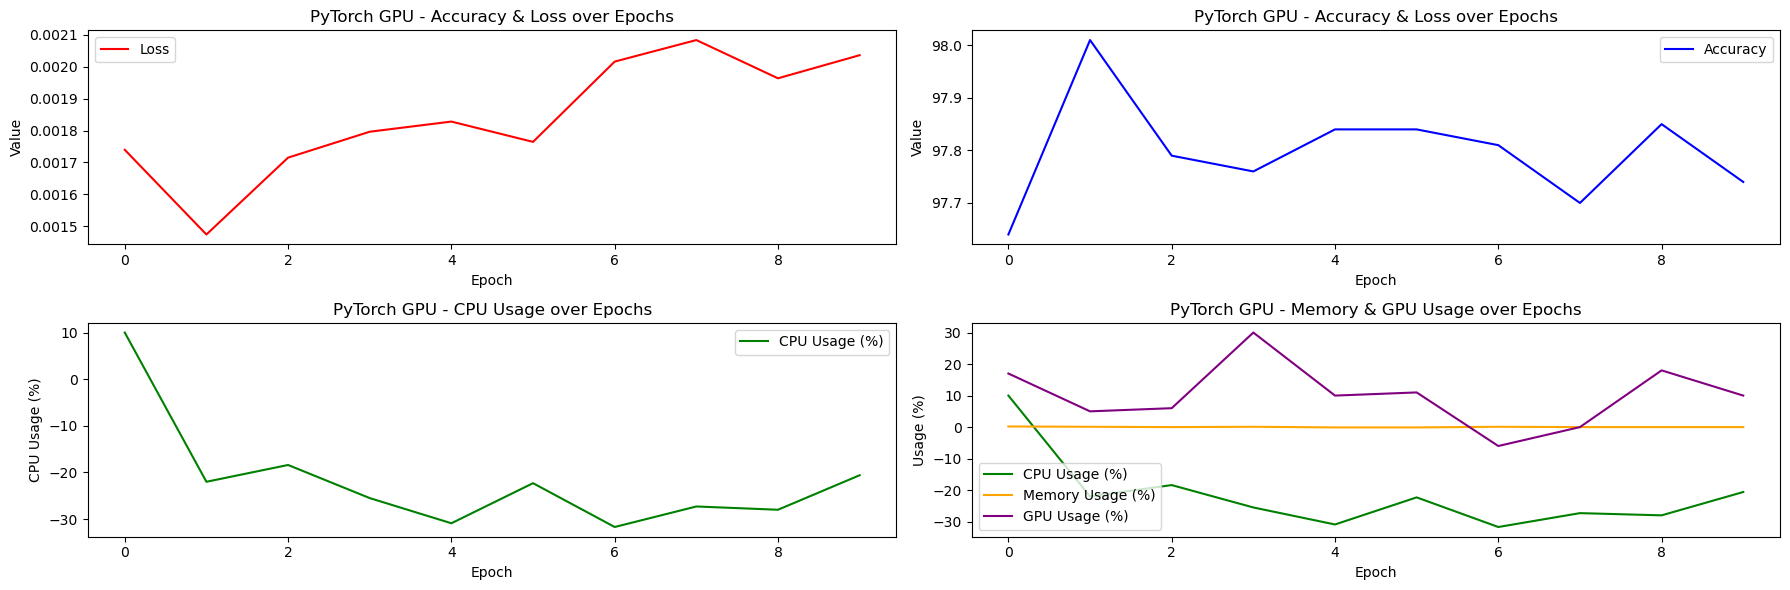

In [45]:
# Plot results for GPU
plot_results(epochs=10, 
                accuracies=accuracies_gpu, 
                losses=losses_gpu, 
                cpu_usage=cpu_usage_gpu, 
                gpu_usage=gpu_usage_gpu, 
                memory_usage=memory_usage_gpu, 
                model_name='PyTorch GPU')
